In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset
import torch.nn as nn

import matplotlib.pyplot as plt

# 1. define your dataloader

In [2]:
transform_list = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.131], std=[0.289])])
dataset = datasets.MNIST(root='/tmp/', train=True, download=True, transform=transform_list)
dataset = Subset(dataset, range(2000))

loader = torch.utils.data.DataLoader(
      dataset=dataset,
      batch_size=500,
      shuffle=False)

# 2. define your model

In [3]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.flatten(1)

n_hidden = 2
hidden_size = 10
device = 'cuda'
layers = [Flatten(), nn.Linear(28 * 28, hidden_size), nn.ReLU()] + \
         [nn.Linear(hidden_size, hidden_size), nn.ReLU()] * (n_hidden - 1) + \
         [nn.Linear(hidden_size, 10), nn.LogSoftmax(dim=1)]
model = nn.Sequential(*layers).to(device)

# 3. define your loss function
For this example here we will compute the MC-sampled Fisher Information Matrix using only 1 sample for each example.

In [4]:
def loss_fim_mc_estimate(input, target):
    log_sm = model(input)
    probs = torch.exp(log_sm)
    random_target = torch.multinomial(probs, 1)
    random_log_sm = torch.gather(log_sm, 1, random_target)
    return random_log_sm

# 4. create your generator

In [5]:
from nngeometry.pspace import M2Gradients

m2_generator = M2Gradients(model=model, dataloader=loader, loss_function=loss_fim_mc_estimate)
n_parameters = m2_generator.get_n_parameters()
print(str(n_parameters) + ' parameters')

8070 parameters


# EWC penalty

We now compute the matrices coefficients using the generator above. Using different representations we get different performances, and also we use more or less memory. But low memory footprint comes at the price of a less accurate approximation of the FIM, and so the gradient that we get from the penalty can be drastically different.

In [6]:
from nngeometry.representations import KFACMatrix, DiagMatrix, DenseMatrix, BlockDiagMatrix
from nngeometry.vector import PVector, from_model

F_kfac = KFACMatrix(m2_generator)
F_blockdiag = BlockDiagMatrix(m2_generator)
F_dense = DenseMatrix(m2_generator)
F_diag = DiagMatrix(m2_generator)

v0 = from_model(model)

display the end of the FIM (zoom of the last layer)

In [7]:
v = torch.rand(n_parameters, device=device)
v.requires_grad = True

v_vec = PVector(model=model, vector_repr=v)

you can now compute a regularizer scalar object and backward through it

In [8]:
regularizer_dense = F_dense.vTMv(v_vec - v0)
g_dense = torch.autograd.grad(regularizer_dense, v)[0]
g_dense.size(), g_dense

(torch.Size([8070]),
 tensor([ 0.0125,  0.0125,  0.0125,  ...,  0.1090,  0.3009, -0.0572],
        device='cuda:0'))

In [9]:
regularizer_bd = F_blockdiag.vTMv(v_vec - v0)
g_bd = torch.autograd.grad(regularizer_bd, v)[0]
g_bd.size(), g_bd

(torch.Size([8070]),
 tensor([ 0.0171,  0.0171,  0.0171,  ..., -0.0754, -0.0672, -0.1008],
        device='cuda:0'))

In [10]:
regularizer_kfac = F_kfac.vTMv(v_vec - v0)
g_kfac = torch.autograd.grad(regularizer_kfac, v)[0]
g_kfac.size(), g_kfac

(torch.Size([8070]),
 tensor([ 0.0056,  0.0056,  0.0056,  ..., -0.0758, -0.0715, -0.1055],
        device='cuda:0'))

In [11]:
regularizer_diag = F_diag.vTMv(v_vec - v0)
g_diag = torch.autograd.grad(regularizer_diag, v)[0]
g_diag.size(), g_diag

(torch.Size([8070]),
 tensor([ 0.0004,  0.0001,  0.0001,  ...,  0.0163,  0.0291, -0.0109],
        device='cuda:0'))

Text(0.5, 1.0, 'Compare 100 elements of the gradient (first layer)')

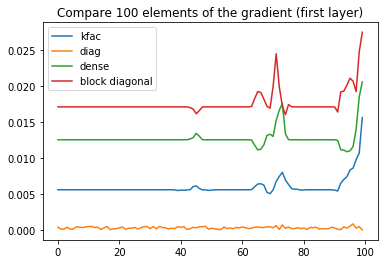

In [12]:
plt.plot(g_kfac[:100].cpu().numpy(), label='kfac')
plt.plot(g_diag[:100].cpu().numpy(), label='diag')
plt.plot(g_dense[:100].cpu().numpy(), label='dense')
plt.plot(g_bd[:100].cpu().numpy(), label='block diagonal')
plt.legend()
plt.title('Compare 100 elements of the gradient (first layer)')

Text(0.5, 1.0, 'Compare 100 elements of the gradient (last layer)')

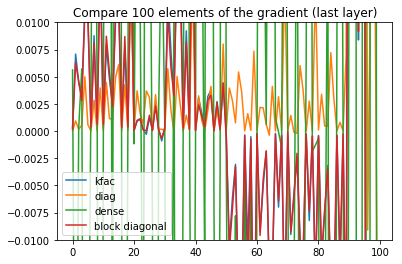

In [13]:
plt.plot(g_kfac[-100:].cpu().numpy(), label='kfac')
plt.plot(g_diag[-100:].cpu().numpy(), label='diag')
plt.plot(g_dense[-100:].cpu().numpy(), label='dense')
plt.plot(g_bd[-100:].cpu().numpy(), label='block diagonal')
plt.ylim(-.01, .01)
plt.legend()
plt.title('Compare 100 elements of the gradient (last layer)')